This post is inspired by [this issue](https://github.com/N-Wouda/ALNS/issues/149) in the ALNS repository.
We aim to efficiently solve a 2D packing of unequally-sized circles onto a minimum number of pallets, using column generation enhanced with some simple heuristics.
<!-- TEASER_END -->

In [1]:
%config InlineBackend.figure_formats = ['svg']

# The problem

We are given sets $C = \{ c_1, c_2, \ldots c_n \}$ of $n$ circles, and $P = \{ p_1, \ldots, p_m \}$ of $m$ rectangular pallets.
Each circle $c \in C$ has a radius $r_c > 0$.
Each pallet $p \in P$ has width $w > 0$ and height $h > 0$.
The goal is to pack all circles onto as few pallets as possible, such that no circles overlap and each circle fits on one of the pallets.

More formally, let $y_p \in \{0, 1\}$ indicate if pallet $p \in P$ is used or not.
Let $x_{cp} \in \{0, 1\}$ indicate if circle $c \in C$ is assigned to pallet $p \in P$.
Finally, let $z^x_{cp}, z^y_{cp} \ge 0$ denote the $(x, y)$-position of the center of circle $c \in C$ on pallet $p \in P$, if $c$ is assigned to $p$.

We aim to optimise the following objective:
$$ \min_{x, y, z} \sum_{p \in P} y_p $$

Such that the following constraints hold:

1. Each circle is packed onto a pallet.
$$ \sum_{p \in P} x_{cp} = 1 \qquad \forall c \in C $$

2. The circles are completely on the pallet (no parts 'stick out').
$$ r_c \le z^y_{cp} \le h - r_c \qquad \forall c \in C,~p \in P $$
$$ r_c \le z^x_{cp} \le w - r_c \qquad \forall c \in C,~p \in P $$

3. The circles do not overlap.
$$ \sqrt{(z^x_{c_1p} - z^x_{c_2p})^2 + (z^y_{c_1p} - z^y_{c_2p})^2} \ge (r_{c_1} + r_{c_2}) x_{c_1p} x_{c_2p}\qquad \forall c_1, c_2 \in C\ (c_1 \ne c_2),~p \in P $$

This problem is tricky to solve, particularly due to the quadratic term of the circle overlap constraint.

# Solution approach

The problem looks a little like the cutting stock problem (CSP), but then in two dimensions, for circles instead of lines.
CSP can be solved efficiently using column generation, by iteratively generating cutting *patterns*: a subset of lines that can that can be cut from a single beam.
We will attempt to do the same thing here for our problem.

Consider the set $\mathcal{K}$ of all cutting patterns of circles from a single pallet.
Each pattern $k \in \mathcal{K}$ is a subset of the circles $C$, such that all circles $c \in k$ can be cut from the same pallet.
With some abuse of notation, let $y_k \in \{0, 1\}$ now indicate whether pattern $k \in \mathcal{K}$ is selected.
The main or master problem we want to solve is then simply the following set covering problem
$$ \min_{y} \sum_{k \in \mathcal{K}} y_k $$
such that
$$ \sum_{k \in \mathcal{K}} \mathbf{1}_{c \in k} y_{k} \ge 1 \qquad \forall c \in C $$
$$ y_k \in \{0, 1\} \qquad \forall k \in \mathcal{K} $$

The set $\mathcal{k}$ is exponentially large, which makes solving this problem directly prohibitively expensive.
This is where column generation comes in: rather than solving the problem with *all* patterns, we start with a subset of them, and iteratively add new patterns that will improve the current solution.

In particular, suppose we start with some subset $K \subset \mathcal{K}$ of initial patterns.
If we solve the LP relaxation of the above problem, we can obtain dual multipliers $\pi_c$ ($c \in C$) for each of the cover constraints.
Solving a pattern-generating subproblem lets us then obtain a new pattern that has a negative reduced cost, that is, a pattern that will improve the current solution if it is included into the set $K$.
This subproblem has the following form:
$$ \min_{x, z} 1 - \sum_{c \in C} \pi_c x_c $$
such that
1. The selected circles fit in the pallet area. This is a valid inequality, and not strictly necessary for optimality.
$$ \sum_{c \in C} \pi r_c^2 x_c \le w \times h $$

2. The circles are completely on the pallet (no parts 'stick out').
$$ r_c \le z^y_{c} \le h - r_c \qquad \forall c \in C$$
$$ r_c \le z^x_{c} \le w - r_c \qquad \forall c \in C$$

3. The circles do not overlap.
$$ (z^x_{c_1} - z^x_{c_2})^2 + (z^y_{c_1} - z^y_{c_2})^2 \ge (r_{c_1} + r_{c_2})^2 (x_{c_1} + x_{c_2} - 1) \qquad \forall c_1, c_2 \in C\ (c_1 \ne c_2) $$

If we can find a solution $(x^*, z^*)$ to this problem with a negative objective value, an improving pattern $k^* \subset C$ contains circle $c \in C$ iff $x^*_c = 1$.
Note that:
1. We do not need to find the "most negative" objective value - just any negative value suffices.
2. If we start with a good set of initial patterns $K$, we do not have to find too many new patterns. That should speed up the search quite a bit.

Let's write some code for the column generation method.
I will use Gurobi to implement these.

In [2]:
from dataclasses import dataclass

import gurobipy as gp
import numpy as np

In [3]:
@dataclass
class Instance:
    """
    A simple data class for the instance data. This instance can be
    further restricted to a particular pattern ("sub Instance").
    """
    radii: np.ndarray
    width: float
    height: float

    def __len__(self):
        return len(self.radii)
        
    def areas(self):
        return np.pi * self.radii ** 2

    def pallet_area(self):
        return self.width * self.height
    
    def restrict_to(self, pattern):
        return Instance(self.radii[pattern], self.width, self.height)

In [4]:
class MasterProblem:
    def __init__(self, patterns):
        """
        Constructs the master problem.
        """
        self.patterns = patterns
        self.model = gp.Model("master")
        y = self.model.addMVar(len(patterns), obj=1, vtype="B")
        self.model.addConstr(np.array(patterns).T @ y >= 1)
        self.model.update()

    def add_pattern(self, pattern):
        """
        Add the given pattern to the model.
        """
        self.patterns.append(pattern)
        self.model.addVar(
            obj=1,
            vtype="B",
            column=gp.Column(pattern.tolist(), self.model.getConstrs())
        )
        
        self.model.update()

    def solve(self):
        """
        Solves the mode and returns the packing patterns used in an optimal 
        integer solution.
        """
        self.model.optimize()

        return [
            pattern
            for pattern, var in zip(self.patterns, self.model.getVars())
            if var.x > 0
        ]

    def objective(self):
        return self.model.objVal

    def relax(self):
        """
        Relax the model as an LP, solve it, and return the constraints' dual
        multipliers.
        """
        m = self.model.relax()
        m.optimize()
        return np.array([constr.pi for constr in m.getConstrs()])

In [5]:
def stop_negative_reduced_cost_callback(model, where):
    # Stop the solver process once we find a pattern that has a negative
    # reduced cost (== an improving pattern).
    if where == gp.GRB.Callback.MIPNODE:
        if model.cbGet(gp.GRB.Callback.MIPNODE_OBJBST) < 0:
            model.terminate()   


class SubProblem:
    def __init__(self, instance):
        """
        Constructs the exact pattern-generating subproblem for the given
        circle radii, and pallet size.
        """
        self.model = gp.Model("sub")
        self.model.setParam("NonConvex", 2)

        radii = instance.radii

        self.x = self.model.addMVar(len(radii), obj=0, vtype="B")
        zx = self.model.addMVar(len(radii), lb=radii, ub=instance.width - radii)
        zy = self.model.addMVar(len(radii), lb=radii, ub=instance.height - radii)

        self.model.addConstr(instance.areas() @ self.x <= instance.pallet_area())

        # The overlap constraint is symmetric, so we only need to add each (i, j)
        # pair once.
        for i in range(len(radii) - 1):
            for j in range(i + 1, len(radii)):
                lhs = (zx[i] - zx[j]) ** 2 + (zy[i] - zy[j]) ** 2
                min_dist = radii[i] + radii[j]
                rhs = min_dist ** 2 * (self.x[i] + self.x[j] - 1)
                self.model.addConstr(lhs >= rhs)

        self.model.update()

    def solve(self, coeffs):
        """
        Solves the subproblem with objective 1 - coeffs @ x. Returns a
        newly generated pattern. You can use the objective() to determine
        if that pattern is an improvement.
        """
        self.model.setObjective(1 - coeffs @ self.x)
        self.model.optimize(stop_negative_reduced_cost_callback)
        return self.x.x

    def objective(self):
        return self.model.objVal

## Utility methods

We need a utility method to run the solver routine of generating new patterns, inspecting their value, and adding them to the master problem.
The `solve` method handles this.
Additionally, our generated solution encodes the packing plan only implicitly: we know which circles to pack on which pallets according to some pattern, but do not know exactly where to place which circle *on* the pallet.
The `packing_plan` method generates such a packing plan for us, given a list of radii of the circles in a pattern.
This method gives us `is_feasible_pattern` 'for free', which we can use to determine the feasibility of a particular pattern.
Finally, given a set of patterns, we can also visualise the solution.
The `plot` method will be used for this.

In [6]:
def solve(master, sub):
    while True:
        pi = master.relax()
        new_pattern = sub.solve(pi)
        master.add_pattern(new_pattern)

        if sub.objective() >= 0:
            break

    return master.solve()

In [7]:
def packing_plan(instance):
    """
    Given a single-pallet instance, this method returns a packing plan:
    for each circle, it returns an (x, y) position for its midpoint on
    the pallet. The method assumes that a feasible plan exists.
    """
    m = gp.Model()
    m.setParam("NonConvex", 2)

    radii = instance.radii

    x = m.addMVar(len(radii), lb=radii, ub=instance.width - radii)
    y = m.addMVar(len(radii), lb=radii, ub=instance.height - radii)

    for i in range(len(radii) - 1):
        for j in range(i + 1, len(radii)):
            lhs = (x[i] - x[j]) ** 2 + (y[i] - y[j]) ** 2
            rhs = (radii[i] + radii[j]) ** 2
            m.addConstr(lhs >= rhs)

    m.optimize()

    return zip(x.x, y.x, radii)


def is_feasible_pattern(instance):
    area = instance.areas().sum()
    pallet_area = instance.pallet_area()

    if (area / pallet_area) > (np.pi / 4):
        # I am not sure if this is a true bound for all cases, but
        # I am going to assume one cannot do better than the density
        # of packing a unit circle in a unit square.
        return False

    try:
        packing_plan(instance)
        return True
    except gp.GurobiError:
        return False

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


def plot(patterns, instance):
    cols = 4
    rows, remainder = divmod(len(patterns), cols)
    rows = rows + 1 if remainder > 0 else rows

    figsize = (cols * instance.width, rows * instance.height)
    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    axes = axes.flatten()

    for ax in axes[:len(patterns)]:  # these axes will be used
        ax.set_xlim([0, instance.width])
        ax.set_ylim([0, instance.height])

        ax.tick_params(
            which="both",
            bottom=False,
            left=False,
            labelbottom=False,
            labelleft=False,
        )

    for ax in axes[len(patterns):]:  # these axes are not used
        ax.set_axis_off()

    # A pattern may repeat a particular circle. To avoid placing that
    # circle multiple times, we track which circles have already been
    # packed on earlier pallets.
    packed = np.zeros(len(instance.radii), dtype=bool)

    for ax, pattern in zip(axes, patterns):
        pattern = pattern.astype(bool)
        circles = instance.restrict_to(pattern & ~packed)
        packed[pattern] = True

        for (*xy, r) in packing_plan(circles):
            ax.add_patch(Circle(xy, r))

    plt.tight_layout()
    plt.plot()

## Generating initial patterns

As we will see later, it can matter quite a bit which initial set of patterns $K$ is supplied to the algorithm.
Here I present two very simple heuristics for generating such patterns, `all_unique` and `greedy`.

In [9]:
def all_unique(instance):
    """
    This initial set of patterns packs each circle on a
    separate pallet.
    """
    return [pattern for pattern in np.eye(len(instance))]

In [10]:
def greedy(instance):
    """
    A simple greedy strategy that packs the circle with greatest
    radius first, and tries to insert each circle into existing 
    patterns.
    
    Note that this can be quite slow when the instance is large.
    """
    radii = instance.radii
    patterns = [np.zeros_like(radii, dtype=bool) for _ in radii]
    unpacked = np.argsort(radii).tolist()

    while len(unpacked) != 0:
        circle = unpacked.pop()  # largest unpacked circle

        for pattern in patterns:
            pattern[circle] = True
            circles = instance.restrict_to(pattern)

            if is_feasible_pattern(circles):
                # This is a feasible assignment, so we pack the circle
                # in this pattern and stop the search.
                break
            else:
                # Cannot feasibly pack this circle into the pattern, 
                # so revert and continue
                pattern[circle] = False

    # Only return those patterns that are not empty. Since we created
    # one pattern for each circle above, many of those patterns are 
    # unused and should not be returned.
    return [pattern for pattern in patterns if pattern.any()]

# Numerical experiments

In this part we run the various algorithms to see how they perform.
To ensure reproducability, we first fix a seed.

In [11]:
np.random.seed(42)

def make_instance(n: int):
    radii = np.random.rand(n)
    width, height = 2.4, 2.0
    return Instance(radii, width, height)

## A small example

We first solve a small example with $n = 20$ circles.
Let's see how much the initial pattern selection matters.

In [12]:
instance = make_instance(n=20)

In [13]:
initial_patterns = all_unique(instance)
master = MasterProblem(initial_patterns)
sub = SubProblem(instance)

%time patterns = solve(master, sub)

Set parameter Username
CPU times: total: 12 s
Wall time: 5.2 s


In [14]:
initial_patterns = greedy(instance)
master = MasterProblem(initial_patterns)
sub = SubProblem(instance)

%time patterns = solve(master, sub)

CPU times: total: 516 ms
Wall time: 194 ms


It's clear from the above measurements that the initial patterns $K$ have a significant influence on overall performance.
This suggests it might be worthwhile to explore if we can do better than `greedy`!

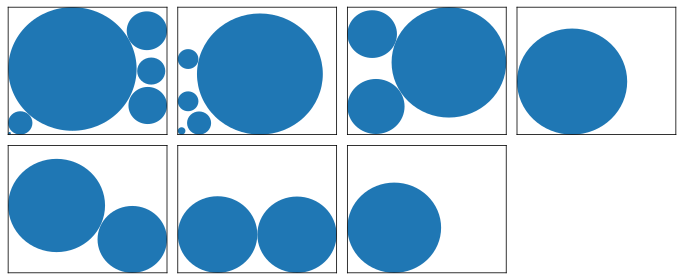

In [15]:
plot(patterns, instance)

This instance cannot be packed on less than seven pallets.
The plot above shows a possible packing.

## A bigger example

Let's increase the instance size a bit, to $n = 50$.
Such instances are quite a bit harder to solve.

In [16]:
instance = make_instance(n=50)

In [17]:
initial_patterns = greedy(instance)
master = MasterProblem(initial_patterns)
sub = SubProblem(instance)

%time patterns = solve(master, sub)

CPU times: total: 29 s
Wall time: 10.8 s


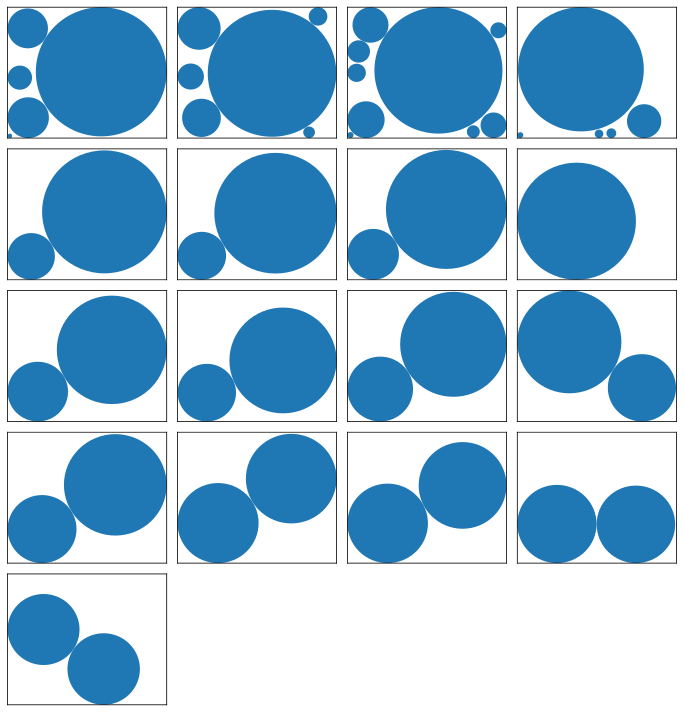

In [18]:
plot(patterns, instance)

# Generating patterns heuristically

So far, we have only used `SubProblem` to generate new patterns.
This uses Gurobi, and can be somewhat slow.
Can we do better if we initially generate patterns using some sort of heuristic, and only switch to `SubProblem` when the heuristic turns out to be ineffective?

In [19]:
class HeuristicSubProblem:
    def __init__(self, instance):
        self.instance = instance
        self.exact = SubProblem(instance)
        self.obj = np.inf

    def solve(self, coeffs):
        """
        Applies a merit-based heuristic (similar to the merit rule for
        Knapsack) to determine a new pattern. If the heuristic does not
        find an improving pattern, the method defaults to an exact 
        formulation that exhaustively searches for an improving pattern.
        """
        merit = coeffs / self.instance.radii
        circles = np.argsort(merit).tolist()
        pattern = np.zeros_like(coeffs, dtype=bool)

        while len(circles) != 0:
            circle = circles.pop()  # circle with greatest merit

            if np.isclose(merit[circle], 0.):
                # This circle adds nothing to the reduced cost, so we can
                # freely skip it.
                continue

            pattern[circle] = True
            if not is_feasible_pattern(instance.restrict_to(pattern)):
                pattern[circle] = False

        self.obj = 1 - coeffs @ pattern

        if self.obj >= 0:  # is not an improving pattern; try exact method
            pattern = self.exact.solve(coeffs)
            self.obj = self.exact.objective()

        return pattern

    def objective(self):
        return self.obj

Let's retry the previously solved instance, but now using the heuristic for the subproblem.

In [20]:
master = MasterProblem(initial_patterns)
sub = HeuristicSubProblem(instance)

%time patterns = solve(master, sub)

CPU times: total: 9.58 s
Wall time: 2.7 s


Much faster! Can we now solve an instance with $n = 100$ circles?

In [21]:
instance = make_instance(n=100)

In [22]:
initial_patterns = greedy(instance)
master = MasterProblem(initial_patterns)
sub = HeuristicSubProblem(instance)

%time patterns = solve(master, sub)

CPU times: total: 31.2 s
Wall time: 9.22 s


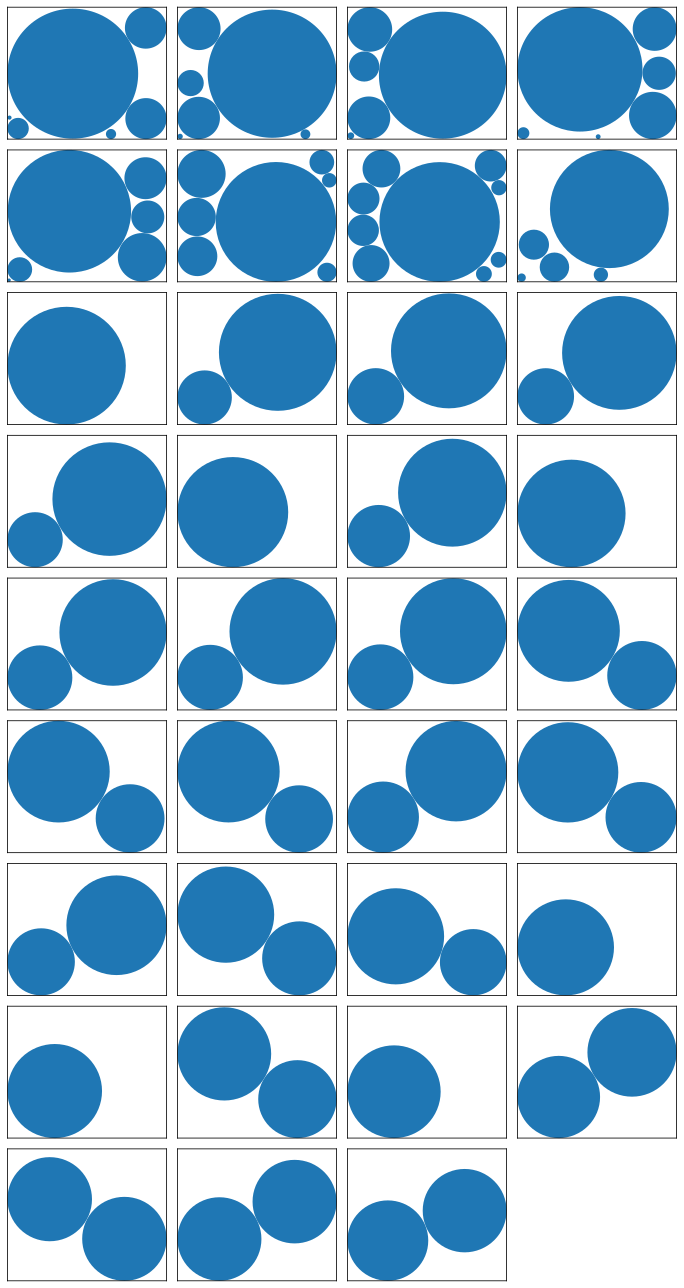

In [23]:
plot(patterns, instance)

# Conclusion

In this notebook we explored how to solve the 2D bin-packing of unequal circles on rectangular pallets.
We used column generation for this, using simple heuristics to generate the initial packing patterns and improve the generation of new packings.
These turn out to work very well for instances with up to 100 circles.

What might be interesting to explore further is how to heuristically determine the initial pattern set $K$, and the generation of new patterns.
Our current method is extremely simple and can surely be improved.
This might be done using for example [ALNS](https://github.com/N-Wouda/ALNS), or another heuristic altogether.